# Text Analysis
By Maryah Garner

## Table of Contents
* [Learning Outcomes](#CLearningOutcomes)
* [Glossary of Terms](#Glossary)
* [Setup - Load Python Packages](#setup)
* [Motivation: Grant Proposal Abstracts ](#Motivation)
    * [Load the Data](#Load)
* [Prepair the Data](#Prepairing)
* [Preparing Text Data for Natural Language Processing (NLP)](#Topic)
* [Latent Dirichlet Allocation (LDA)](#LDA)
* [N-grams](#N-grams)
* [TF-IDF : Weighting terms based on frequency  ](#TF-IDF)
* [Visualize the project by topic ](#Visualize)
* [Checkpoints](#Checkpoints)

In this notebook, we are going to analyze abstracts of grants using topic modeling to examine the type of work that is being funded by the National Cancer Institute (NCI). 

## Learning Outcomes <a class="anchor" id="CLearningOutcomes"></a>


In this notebook, you will...
* Learn how to transform a corpus of text into a structured matrix format so that we can apply natural language processing (NLP) methods
* Learn the basics and applications of topic modeling
* Learn how to do document tagging and evaluate the results
* Learn how to visualize your data by topics 

 
## Glossary of Terms <a class="anchor" id="Glossary"></a>

Glossary of Terms:

* **Corpus**: A corpus is the set of all text documents used in your analysis; for example, your corpus of text may include hundreds of research articles.

* **Tokenize**: Tokenization is the process by which text is separated into meaningful terms or phrases. In English this is easy to do for individual words, as they are separated by whitespace; however, it can get more complicated to  automate determining which groups of words constitute meaningful phrases. 

* **Stemming**: Stemming is normalizing text by reducing all forms or conjugations of a word to the word's most basic form. In English, this can mean making a rule of removing the suffixes "ed" or "ing" from the end of all words, but it gets more complex. For example, "to go" is irregular, so you need to tell the algorithm that "went" and "goes" stem from a common lemma, and should be considered alternate forms of the word "go."

* **TF-IDF**: TF-IDF (term frequency-inverse document frequency) is an example of feature engineering where the most important words are extracted by taking into account their frequency in documents and the entire corpus of documents as a whole.

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of words that often appear together are clustered into topics. Typically, the words in one topic should be related and make sense (e.g. boat, ship, captain). Individual documents can fall under one topic or multiple topics. 

* **LDA**: LDA (Latent Dirichlet Allocation) is a type of probabilistic model commonly used for topic modeling. 

* **Stop Words**: Stop words are words that have little semantic meaning but occur very frequently, like prepositions, articles and common nouns. For example, every document (in English) will probably contain the words "and" and "the" many times. You will often remove them as part of preprocessing using a list of stop words.


## Setup - Load Python Packages <a class="anchor" id="setup"></a>

Install and import libraries

In [1]:
# Install package for natural language processing
%pip install nltk

# data manipulation
import pandas as pd
import numpy as np
import os

# text analysis tools
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import preprocessing
from nltk import SnowballStemmer
import string

# visualization tools
import matplotlib as mplib
import matplotlib.pyplot as plt 
import seaborn as sns  

Note: you may need to restart the kernel to use updated packages.


## Motivation: Grant Proposal Abstracts <a class="anchor" id="Motivation"></a>

In this notebook, we will use text analysis on the grant proposal abstracts funded by NCI in order to determine what types of topics the NCI is Funding. Note that we do not have a pre-compiled list of topics that we are matching to the abstracts. Instead, we want to explore the data and use unsupervised learning in order to generate the topics.

### Load the Data<a class="anchor" id="Load"></a>

To start, we'll load the data into a pandas DataFrame from our class folder. We will be analyzing the abstracts of grant proposals. For demonstration purposes of this class we will only use year 2016 and we will filter for projects that are funded by the National Cancer Institute.

In [2]:
# Specify a path with the data folder
# Change "NAME" to your name as recorded on your computer
# path = 'C:/Users/NAME/PADM-GP_2505/Data/'
Path = "/Users/maryahhatherillgarner/Desktop/2023 Spring NYU Data Analytics/PADM-GP_2505/Data"

In [3]:
# Read-in a CSV file
Abstracts_2016 = pd.read_csv(Path + '/Abstracts/RePORTER_PRJABS_C_FY2016_new.csv', encoding='latin-1')

### Explore the Abstract Data <a class="anchor" id="Explore"></a>
Our text data table has 2 fields:

- `APPLICATION_ID` - The Unique identifier of the project record .
- `ABSTRACT_TEX` - text of abstract.

Let's take a look at examples of the values:

In [4]:
# Show full text in a cell
pd.set_option('display.max_colwidth', -1)
# look at the first 2 rows again
Abstracts_2016.head(2)

/var/folders/75/wl43s0z50w90g_t4ln1tm9680000gn/T/ipykernel_8566/2702094089.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,APPLICATION_ID,ABSTRACT_TEXT
0,8002706,"Abstract Title: Measuring the quality of genomic health services in the VA: A pilot PI: Mark Meterko, PhD Background: The rate at which clinically relevant genomic tests are being developed is accelerating, particularly for chronic adult-onset conditions such as heart disease, mental illness and cancer. These test results can affect medical management and long-term health. Consistent with this trend, the VA is increasing its delivery of genomic services including testing for diagnostic and predictive purposes. Research to compare the clinical effectiveness of genomic service delivery models is critical to ensure that VA develops, implements and disseminates genomic services that are both effective and veteran-centered. Objectives(s): The overall objective of this pilot study is to adapt and augment measures of genomics care process and patient outcomes to address the unique characteristics and needs of veteran patients receiving genomic medical services. Specifically, the proposed study has four aims: (1) Identify in detail the key process steps and patient outcomes of VA genomic services, (2) Develop two data collection instruments to measure those (a) process characteristics and (b) outcome dimensions, (3) Rigorously test those instruments for comprehension (content) and ease of administration (format), and (4) Revise the instruments based on that testing for use in a future comparative clinical effectiveness study of genomics medical service model. Research Design & Methodology: The proposed pilot study will use classical scale development methodology including a review of the literature, in-depth provider interviews, patient focus groups, as well as cognitive interviewing to develop process and patient outcome measurement instruments. Each study aim will be the focus of its own phase of the pilot and will employ specific, appropriate methodologies following the overall model outlined by Dillman. [31]"
1,8005208,"Project Summary - Demand, Cost, and Access of Radiotherapy in VA, Fee, & Non-VA Facilities Project Background: Radiotherapy is a treatment provided by the Veterans Health Administration (VA) to patients as a result of the diagnosis of certain cancers. Radiotherapy services may be provided directly by the VA, or payment for these services may be made to non-VA providers in the community under certain circumstances (fee-basis or contracted care in non-VA sites). Additionally, veterans that are dually eligible (e.g., VA and Medicare) may also choose to receive care at non-VA facilities that is paid for by the Medicare program. Veterans (independent of age) may also carry private insurance, though care received in such circumstances is difficult for the VA to track. Circumstances that may necessitate the use of the VA-fee basis program include when VA facilities are not capable of furnishing economical hospital care or medical services because of geographic inaccessibility, or are not capable of furnishing the care or services required. Because radiotherapy is a limited resource within the VA's health care system, nationally, much of this care is purchased by the VA from community resources. Preliminary cost and utilization data demonstrate considerable growth in the demand and expenditures for radiotherapy services provided under VA auspices over the past 8 years. The current economic downturn, expansion of benefits to veterans (e.g., categories 6, 7, 8), and Medicare payment reductions for radiotherapy have raised access and capacity concerns of VA radiotherapy. In turn these are important planning questions for the VA national purchased care (VA Fee) director, Patricia J. Gheen and the VA national director radiation oncology led by Dr. Michael P. Hagan, both of whom are key advisors on this study. Project Objectives: 1) Identify trends (2000 to 2008) in the fiscal year-specific use and expenditures in radiotherapy services across the VA that are provided in VA (salaried and c

### Read in the Projects data
For this notebook we will focus on projects funded by the NATIONAL CANCER INSTITUTE as we have in previous notebooks. To do this we must first join the Abstracts data with the projects data to filter for NCI projects. 

In [5]:
# Read-in the 2016 projects data
grants_2016 = pd.read_csv('/Users/maryahhatherillgarner/Desktop/2023 Spring NYU Data Analytics/PADM-GP_2505/Data/Projects/RePORTER_PRJ_C_FY2016_new.csv',
                          usecols=['APPLICATION_ID','IC_NAME', 'TOTAL_COST'], encoding='latin-1')

# View the first 5 observations 
grants_2016.head(10)

,APPLICATION_ID,IC_NAME,TOTAL_COST
0,9041629,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,296953.0
1,9039665,NATIONAL INSTITUTE OF MENTAL HEALTH,438750.0
2,9036357,NATIONAL CANCER INSTITUTE,554053.0
3,9067675,NATIONAL CENTER FOR INJURY PREVENTION AND CONTROL,1410000.0
4,9067537,NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES,362133.0
5,9069029,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",354161.0
6,9042378,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,369716.0
7,9468933,NATIONAL INSTITUTE OF GENERAL MEDICAL SCIENCES,25623.0
8,9058021,NATIONAL INSTITUTE ON DRUG ABUSE,191812.0
9,9068350,NATIONAL INSTITUTE OF NEUROLOGICAL DISORDERS AND STROKE,59970.0


## Prepair the Data  <a class="anchor" id="Prepairing"></a>

###  Connect the Abstract data with the Projects data
For this notebook we will focus on projects funded by the NATIONAL CANCER INSTITUTE as we have in the provious notebooks. To do this we must first join the Abstracts data with the projects data to filter to NCI projects. 

### Subset for Cancer Projects
In this notebook we will select all Projects that have the word Cancer in the NIH_SPENDING_CATS. 

In [6]:
# Use a conditional subset to select progects that have NATIONAL CANCER INSTITUTE as the IC_NAME
NCI_projects = grants_2016[grants_2016['IC_NAME'] =='NATIONAL CANCER INSTITUTE']

# Reset index
NCI_projects = NCI_projects.reset_index()

# view the first 5 observations
NCI_projects.head()

,index,APPLICATION_ID,IC_NAME,TOTAL_COST
0,2,9036357,NATIONAL CANCER INSTITUTE,554053.0
1,11,9047257,NATIONAL CANCER INSTITUTE,438929.0
2,13,9264070,NATIONAL CANCER INSTITUTE,54438.0
3,31,9057474,NATIONAL CANCER INSTITUTE,362601.0
4,44,9125588,NATIONAL CANCER INSTITUTE,712498.0


In [7]:
NCI_projects.shape

(11291, 4)

### Connect the Abstract data to the NCI_projects dataframe
We will use a left join to merge the data, so that we only get abstracts for NCI projects. We are using a left join instead of a inner join because we want to know how many cancer projects do not have abstracts associated with them. 

In [8]:
# Create a new dataframe by using an inn merge to merge the NCI_projects and Abstracts_2016 dataframes
# merging on PI_NAME
nci_abstracts = pd.merge(NCI_projects, Abstracts_2016, on='APPLICATION_ID', how = 'left')
nci_abstracts.shape

(11291, 5)

In [9]:
nci_abstracts.head()

,index,APPLICATION_ID,IC_NAME,TOTAL_COST,ABSTRACT_TEXT
0,2,9036357,NATIONAL CANCER INSTITUTE,554053.0,"? DESCRIPTION (provided by applicant): Loss of the tumor suppressor phosphatase and tensin homolog (PTEN), the key negative regulator of Phosphatidylinositol 3-Kinase (PI3K) activity, is one of the most common genetic events in primary prostate cancer (PCa). Moreover, its frequency further increases in metastatic PCa, indicating that hyperactivation of the PI3K pathway plays an important role in the pathogenesis of PCa and implicating PI3K as an attractive target in this tumor type. However, early clinical trials with PI3K inhibitors in multipe cancer types, including PCa, have been disappointing. The clinical efficacy of these early PI3K inhibitors, which were largely pan-PI3K inhibitors that block the action of all Class I PI3K isoforms, may have been limited by their lack of isoform specificity. Indeed, preclinical work and emerging clinical trials suggest that inhibitors of individual isoforms may achieve greater efficac with fewer side effects. For example, Cal101, an inhibitor of the p110d isoform of PI3K, has demonstrated remarkable clinical efficacy in certain B-cell malignancies. Early unpublished clinical results also suggest that p110a inhibitors are outperforming pan-PI3K inhibitors in luminal breast cancer. Because the PIK3CA gene encoding p110a is frequently mutated in tumors, p110a has garnered the bulk of the attention from pharmaceutical and basic researchers. However, using a murine genetic model we identified p110ß as a key target in PTEN-null prostate tumors. We and others have subsequently shown that human PTEN-null prostate cancer cell lines are selectively dependent on p110ß. We have further identified Kin-193, also known as AZD6482, as a potent and specific p110ß inhibitor suitable for studies in vitro and in mice. Notably, a new p110ß inhibitor, GSK2636771, is now in clinical trials in patients with PTEN-deficient advanced solid tumors (NCT01458067). Therefore, it is both imperative and timely to carefully investigate p110ß inhibitors in preclinical settings. In this gant we propose to evaluate the therapeutic potential of this novel class of inhibitors in prostate cancer in vitro and in vivo using human cancer cell lines, genetic mouse models as well as primary human prostate tumor explants, to develop biomarkers predictive of response to p110ß inhibition, and to identify optimal combination partner agents for p110ß-based therapy. The studies proposed in this grant will likely provide important information that will help to optimize the clinical impact of this class of inhibitors in PTEN-deficient tumors."
1,11,9047257,NATIONAL CANCER INSTITUTE,438929.0,"? DESCRIPTION (provided by applicant): Soft tissue sarcomas (STS) are a heterogeneous group of mesenchymal tissue cancers, with over 50 histological sub-types. Regardless of type, virtually all STS are treated the same; i.e. with doxorubicin (DOX) followed by resection, if possible. More than 20% of STS are non-resectable and, of those that are, more than 20% recur. For non-resectable or recurring patients, median survival is a dismal 18 months. Perhaps because of its rarity, no new front-line agents have been developed for STS in decades. Among newer agents being developed for STS, TH-302 is showing exceptional promise. TH-302 is an alkylating pro-drug that is activated only in regions of severe hypoxia, and is currently in a phas III trial in combination with DOX in unresectable STS. The primary endpoint of this trial is overal survival with a secondary endpoint of objective radiological response with RECIST 1.1. RECIST responses rarely correlate with survival responses in soft tissue sarcomas, however. The purpose of this work is to develop MR imaging biomarkers that can predict response to DOX and/or TH-302, with the overarching hypothesis that distinct MRI-defined sub-regions of tumors will have differential responses to these agents. Because th

#### How many cancer projects to not have an abstract?

In [10]:
nci_abstracts[pd.isnull(nci_abstracts['ABSTRACT_TEXT'])].count()

index             52
APPLICATION_ID    52
IC_NAME           52
TOTAL_COST        12
ABSTRACT_TEXT     0 
dtype: int64

Out of the 11291 Cancer projects, 52 of them to not have an abstract. This is about 2% of the total projects. For the purposes of this notebook, we will just remove these projects, but in your ownn projects I would would recommend investigating the projects you have to drop from your text analysis due to missing abstracts. 

### Remove the projects with missing abstracts 

In [11]:
# Drop the projects with missing abstracts
nci_abstracts = nci_abstracts.dropna(subset = ['ABSTRACT_TEXT'])

# Look at the number of rowa and columns of the data frame
nci_abstracts.shape

(11239, 5)

### Save the abstracts to a list
In order to properly process the data for text analysis, we need to convert it from a dataframe to a list, so we will save the values of the column `ABSTRACT_TEXT` to a list.

In [12]:
abstracts_list = nci_abstracts['ABSTRACT_TEXT'].values.tolist()

# look at the first element of the list, which is the first abstract
abstracts_list[0]

'?    DESCRIPTION (provided by applicant): Loss of the tumor suppressor phosphatase and tensin homolog (PTEN), the key negative regulator of Phosphatidylinositol 3-Kinase (PI3K) activity, is one of the most common genetic events in primary prostate cancer (PCa). Moreover, its frequency further increases in metastatic PCa, indicating that hyperactivation of the PI3K pathway plays an important role in the pathogenesis of PCa and implicating PI3K as an attractive target in this tumor type. However, early clinical trials with PI3K inhibitors in multipe cancer types, including PCa, have been disappointing. The clinical efficacy of these early PI3K inhibitors, which were largely pan-PI3K inhibitors that block the action of all Class I PI3K isoforms, may have been limited by their lack of isoform specificity. Indeed, preclinical work and emerging clinical trials suggest that inhibitors of individual isoforms may achieve greater efficac with fewer side effects. For example, Cal101, an inhibito

## Topic Modeling <a class="anchor" id="Topic"></a>

We are going to apply topic modeling, an unsupervised learning method, to our corpus to find the high-level topics in our corpus. Through this process, we'll discuss how to clean and preprocess our data to get the best results. Topic modeling is a broad subfield of machine learning and natural language processing. We are going to focus on a common modeling approach called Latent Dirichlet Allocation (LDA).

To use topic modeling, we first have to assume that topics exist in our corpus, and that some small number of these topics can "explain" the corpus. Topics in this context refer to words from the corpus, in a list that is ranked by probability. A single document can be explained by multiple topics. For instance, an article on net neutrality would fall under the topic "technology" as well as the topic "politics". The set of topics used by a document is known as the document's allocation, hence, the name Latent Dirichlet Allocation, each document has an allocation of latent topics allocated by Dirichlet distribution. Latent (or hidden) stands for topics in the documents that are existing but not yet developed or manifest and which can be discovered based on observed data, such as words in the documents. Dirichlet refers to distributions that are taken into account when creating topics: a distribution of words in the topic (which words are more or less probable to belong to a given topic) and a distribution of topics in documents (which topic is more or less probable for a given document). 

We will use topic modeling in order to determine what types of research is done based on the grants' abstracts.

LDA model takes as input a corpus (a collection of text documents). Every text document is tokenized to become a sequence of words (tokens). All unique words across a given corpus are saved as a vocabulary. Text documents are then converted to a matrix of token counts (how often a given unique word from a vocabulary appears in a given text document), e.g.:

|doc# / unique words | 'science' | 'research' | 'cell' | 'DNA' | 'gene' |
|-----------|--------|---------|-------|-------|------|
|document 1 |    0   |    0    |   1   |   5   |  7   |
|document 2 |    1   |    2    |   0   |   1   |  0   |
|document 3 |    1   |    5    |   2   |   0   |  0   |


The LDA model finds the probability of a word appearing in a given topic, and then maps a probability of a topic being assigned to a given document.

## Preparing Text Data for Natural Language Processing (NLP) <a class="anchor" id="NLP"></a>

The first important step in working with text data is cleaning and processing the data, which includes (but is not limited to):
- forming a corpus of text
- stemming and lemmatization
- tokenization
- removing stopwords
- finding words co-located together (N-grams)

The ultimate goal is to transform our text data into a form an algorithm can work with, because a document or a corpus of text cannot be fed directly into an algorithm. Algorithms expect numerical feature vectors with certain fixed sizes, and can't handle documents, which are basically sequences of symbols with variable length. We will be transforming our text corpus into a _bag of n-grams_ to be further analyzed. In this form our text data is represented as a matrix where each row refers to a specific job description (document) and each column is the occurence of a word (feature).

First we will walk through the process for removing punctuation, stemming, and tokenizing, one at a time, using the first abstarct as an example then we will write a funstion to apply these three steps on the entire data set.

### Stemming and Lemmatization - Distilling text data
We want to process our text through _stemming and lemmatization_, or replacing words with their root or simplest form. For example, "systems", "systematic", and "system" are all different words, but we can replace all these words with "system" without sacrificing much meaning. 
- A **lemma** is the original dictionary form of a word (e.g. the lemma for "lies", "lied", and "lying" is "lie").
- The process of turning a word into its simplest form is **stemming**. There are several well-known stemming algorithms -- Porter, Snowball, Lancaster - that all have their respective strengths and weaknesses.

#### Set stemmer at SnowballStemmer
In this notebook, we will use the Snowball Stemmer:

In [13]:
# Examples of how a Stemmer works:
stemmer = SnowballStemmer("english")
print(stemmer.stem('lies'))
print(stemmer.stem('lying'))
print(stemmer.stem('systematic'))
print(stemmer.stem('running'))

lie
lie
systemat
run


### Removing Punctuation
For some purposes, we might want to preserve punctuation. For example, if we wanted to be able to detect sentiment of text, we might want to keep exclamation points, because they signify something about the text. For our purposes, however, we will simply strip the punctuation so that it does not affect our analysis. To do this, we use `string` package, creating a translator that takes any string and "translates" it into a string without any punctuation.

In [14]:
# Before removing punctuation
abstracts_list[0]

'?    DESCRIPTION (provided by applicant): Loss of the tumor suppressor phosphatase and tensin homolog (PTEN), the key negative regulator of Phosphatidylinositol 3-Kinase (PI3K) activity, is one of the most common genetic events in primary prostate cancer (PCa). Moreover, its frequency further increases in metastatic PCa, indicating that hyperactivation of the PI3K pathway plays an important role in the pathogenesis of PCa and implicating PI3K as an attractive target in this tumor type. However, early clinical trials with PI3K inhibitors in multipe cancer types, including PCa, have been disappointing. The clinical efficacy of these early PI3K inhibitors, which were largely pan-PI3K inhibitors that block the action of all Class I PI3K isoforms, may have been limited by their lack of isoform specificity. Indeed, preclinical work and emerging clinical trials suggest that inhibitors of individual isoforms may achieve greater efficac with fewer side effects. For example, Cal101, an inhibito

As you can see, the first abstrate starts with a **?**, once we create a translator that replaces punctuation with empty spaces, this **?** along with all other punctuation will be replaced with an empty space.

In [15]:
# Create translator that replaces punctuation with empty spaces
translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

# Look at the punctuation characters ww will be replacing
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# After removing punctuation
abstracts_list[0].translate(translator)

'     DESCRIPTION  provided by applicant   Loss of the tumor suppressor phosphatase and tensin homolog  PTEN   the key negative regulator of Phosphatidylinositol 3 Kinase  PI3K  activity  is one of the most common genetic events in primary prostate cancer  PCa   Moreover  its frequency further increases in metastatic PCa  indicating that hyperactivation of the PI3K pathway plays an important role in the pathogenesis of PCa and implicating PI3K as an attractive target in this tumor type  However  early clinical trials with PI3K inhibitors in multipe cancer types  including PCa  have been disappointing  The clinical efficacy of these early PI3K inhibitors  which were largely pan PI3K inhibitors that block the action of all Class I PI3K isoforms  may have been limited by their lack of isoform specificity  Indeed  preclinical work and emerging clinical trials suggest that inhibitors of individual isoforms may achieve greater efficac with fewer side effects  For example  Cal101  an inhibito

### Tokenizing

We want to separate text into individual tokens (generally individual words). To do this, we will first write a function that takes a string and splits it up into individual words.

To tokenize, we will use a `.split()` function.

In [17]:
abstracts_list[0].split()[:10]

['?',
 'DESCRIPTION',
 '(provided',
 'by',
 'applicant):',
 'Loss',
 'of',
 'the',
 'tumor',
 'suppressor']

#### Create a tokenize function
We will create a `tokenize` function that does several things at the same time. 
- First, it removes any punctuation using the `translate` method. 
- Then, the `split` method breaks it apart into individual words. 
- Then, using `stemmer.stem`, it creates a list of the stemmed versions of each of those individual words.

In [18]:
# Create a tokenize function
def tokenize(text):
 # translator that replaces punctuation with empty spaces
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation)) 
 # stemmer and tokenizing into words
    return [stemmer.stem(i) for i in text.translate(translator).split()]  

Let's take a look at an example of how this works using the first abstract in our corpus.

In [19]:
tokenize(abstracts_list[0])[:10]

['descript',
 'provid',
 'by',
 'applic',
 'loss',
 'of',
 'the',
 'tumor',
 'suppressor',
 'phosphatas']

What we get out of it is something called a **bag of words**. This is a list of all of the words that are in the abstract, cleaned of all punctuation and stemmed. The paragraph is now represented as as vector of individual words rather than as one whole entity.

#### Create the vectorizer object

We can apply the `tokenize` function to each abstract in our corpus using `CountVectorizer`. This will not only do the tokenizing, but it will also count any duplicates of words and create a matrix that contains the frequency of each word. This will be quite a large matrix (number of columns will be number of unique words), so it outputs the data as a sparse matrix.

We will first create the `vectorizer` object, and then fit it with our abstracts. This should give us back our overall corpus bag of words, as well as a list of features (that is, the unique words in all the abstracts).

In [20]:
vectorizer = CountVectorizer(analyzer="word",        # unit of features are single words rather than characters
                            tokenizer=tokenize,      # function to create tokens
                            ngram_range=(0,1),       # unigrams - single words
                            strip_accents='unicode', # remove accent characters
                            min_df = 0.05,           # only include words with minimum frequency of 0.05
                            max_df = 0.95)           # only include words with maximum frequency of 0.95

#### Bag of words

**This Next sections or code may take a time to run** 

In [21]:
# transform our corpus as a bag of words
bag_of_words = vectorizer.fit_transform(abstracts_list) 

# get features (words)
features = vectorizer.get_feature_names()

/Users/maryahhatherillgarner/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Let's print some of these objects to get an idea of what they look like. We'll just print the first row of the `bag_of_words` matrix as well as the feature names (that is, the column names). Note that because this matrix can get quite large and be quite sparse, the data are stored in a slightly different format, and so the output will look a little different from what you might be used to.

In [51]:
print(bag_of_words)

  (0, 9)	1
  (0, 24)	1
  (0, 28)	1
  (0, 29)	1
  (0, 35)	1
  (0, 39)	1
  (0, 46)	2
  (0, 62)	1
  (0, 76)	1
  (0, 77)	1
  (0, 79)	1
  (0, 88)	1
  (0, 90)	1
  (0, 92)	1
  (0, 93)	1
  (0, 98)	6
  (0, 100)	2
  (0, 112)	1
  (0, 117)	3
  (0, 118)	2
  (0, 129)	3
  (0, 131)	7
  (0, 132)	3
  (0, 138)	1
  (0, 140)	1
  :	:
  (11238, 154)	1
  (11238, 157)	1
  (11238, 163)	2
  (11238, 166)	1
  (11238, 188)	1
  (11238, 209)	4
  (11238, 221)	1
  (11238, 236)	1
  (11238, 242)	1
  (11238, 250)	1
  (11238, 260)	1
  (11238, 270)	1
  (11238, 288)	2
  (11238, 300)	1
  (11238, 337)	1
  (11238, 380)	1
  (11238, 403)	2
  (11238, 417)	1
  (11238, 500)	2
  (11238, 558)	2
  (11238, 563)	1
  (11238, 566)	1
  (11238, 592)	1
  (11238, 601)	1
  (11238, 668)	2


In [23]:
# Display features 20-30
features[20:30]

['abstract',
 'academ',
 'access',
 'accomplish',
 'achiev',
 'acquir',
 'across',
 'act',
 'action',
 'activ']

Now that we have our bag of words, we can start using models such as Latent Dirichlet Allocation.

## Latent Dirichlet Allocation (LDA)  <a class="anchor" id="LDA"></a>

Latent Dirichlet Allocation (LDA) is a statistical model that generates groups based on similarities. This is an example of an **unsupervised machine learning model**. That is, we don't have any sort of outcome variable - we are just trying to group the abstracts into rough categories.

Let's try fitting an LDA model. We first create a `LatentDirichletAllocation` object, then fit it using our corpus bag of words.

In [24]:
# Create an LDA object
lda = LatentDirichletAllocation(learning_method='online')

# fit the LDA object to the bag or words
doctopic = lda.fit_transform(bag_of_words)

#### Pull out the top keywords in each topic
We will use a for-loop to store the top 8 keywords for each topic

In [25]:
# Create an empty list to store the key words for each topic
ls_keywords = []
for i,topic in enumerate(lda.components_):
 #arrange topics in decending order and save the top 8 for word_idx
    word_idx = np.argsort(topic)[::-1][:8]
 # Join the features with the word_idx for each lda component
    keywords = ', '.join(features[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)

0 research, cancer, will, train, for, program, this, develop
1 core, for, project, provid, research, support, resourc, data
2 imag, breast, cancer, for, tumor, is, will, tissu
3 cell, tumor, that, we, t, immun, with, by
4 cancer, risk, with, studi, for, is, are, that
5 that, we, for, protein, is, are, dna, with
6 patient, with, clinic, for, will, treatment, trial, is
7 will, for, genom, develop, cancer, use, be, we
8 that, cancer, cell, is, we, by, will, tumor
9 cancer, program, research, clinic, fund, center, member, is


Not all of these look very helpful! There are way too many common words in the corpus, such as 'for', 'this', 'is' and so on. We need to remove them, because they don't actually have any interesting information about the documents.

### Removing meaningless text - Stopwords

Stopwords are words that are found commonly throughout a text and carry little semantic meaning. Examples of common stopwords are prepositions ("to", "on", "in"), articles ("the", "an", "a"), conjunctions ("and", "or", "but") and common nouns. For example, the words _the_ and _of_ are ubiquitous, so they won't serve as meaningful features, whether to distinguish documents from each other or to tell what a given document is about. You may also run into words that you want to remove based on where you obtained your corpus of text or what it is about. There are many lists of common stopwords available for you to use, both for general documents and for specific contexts, so you don't have to start from scratch.

We can eliminate stopwords by checking all the words in our corpus against a list of commonly occuring stopwords that comes with NLTK.

#### Import and download stopwords form nltk.corpus

In [26]:
# Import stopwords form ltk.corpus
from nltk.corpus import stopwords
# Download the stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maryahhatherillgarner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Set the correct stop words and Tokenize them

In [27]:
# Set the correct stop words 
stop_words = set(stopwords.words('english'))

# Tokenize stop words and store them a stop_words list
stop_words = [tokenize(s)[0] for s in stop_words]

In [46]:
type(stop_words)

list

#### Create Vectorizer

In [28]:
# Create Vectorizer
vectorizer = CountVectorizer(analyzer="word",           # unit of features are single words rather than characters
                            tokenizer=tokenize,         # function to create tokens
                            ngram_range=(0,1),          # unigrams - single words
                            strip_accents='unicode',    # remove accent characters
                            stop_words = stop_words,    # remove stopwords
                            min_df = 0.05,              # only include words with minimum frequency of 0.05
                            max_df = 0.95)              # only include words with maximum frequency of 0.95

#### Create a bag of words

In [29]:
# Create a bag of words
bag_of_words = vectorizer.fit_transform(abstracts_list) # transform our corpus as a bag of words
features = vectorizer.get_feature_names()               # get features (words)

#### Fitting LDA model

In [30]:
# establish LDA model. set n_components = 10 to identify 10 topics
lda = LatentDirichletAllocation(n_components = 10, learning_method='online')

# Fitting LDA model and store your results 
doctopic = lda.fit_transform(bag_of_words)

#### Extract the top keywords (unigrams) in each topic

In [31]:
# Extract the top 10 keywords in each topic
ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:10]
    keywords = ', '.join(features[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)

0 cancer, target, resist, inhibitor, activ, aim, pathway, therapeut, prostat, inhibit
1 cancer, risk, studi, breast, patient, use, intervent, health, treatment, associ
2 research, cancer, train, develop, dr, program, career, provid, mentor, biolog
3 immun, 1, b, respons, infect, 2, leukemia, project, product, specif
4 core, project, provid, data, resourc, servic, support, research, investig, share
5 imag, clinic, develop, use, patient, biomark, method, detect, data, studi
6 cell, regul, activ, express, tumor, signal, role, function, cancer, protein
7 tumor, cell, patient, therapi, cancer, treatment, clinic, target, model, respons
8 gene, dna, genom, mutat, cancer, genet, identifi, protein, sequenc, use
9 cancer, research, program, clinic, center, support, fund, trial, member, institut


## N-grams <a class="anchor" id="N-grams"></a>
We can add more context by creating N-grams. Reducing a document to a bag of words means losing much of its meaning - we put words in certain orders, and group words together in phrases and sentences, precisely to give  them more meaning. If you follow the processing steps we have gone through so far, splitting your document into individual words and then removing stopwords, you will completely lose all phrases like "commander in chief".

One way to address this is to break down each document similarly, but rather than treating each word as an individual unit, treat each group of 2 words, or 3 words, or _n_ words, as a unit. We call is a "bag on _n_-grams", where _n_ is the number of words in each chunk. Then you can analyze which groups of words commonly occur together (in a fixed order).

We will need to change the `ngram_range` variable from `(0,1)` to `(0,2)` to get the  bigrams, to `(0,3)` to get the trigrams, and so on.

##### Create the vectorizer object using bigrams

In [32]:
vectorizer = CountVectorizer(analyzer="word",           # unit of features are single words rather than characters
                            tokenizer=tokenize,         # function to create tokens
                            ngram_range=(0,2),          # allow for bigrams
                            strip_accents='unicode',    # remove accent characters
                            stop_words = stop_words,    # remove stopwords
                            min_df = 0.05,              # only include words with minimum frequency of 0.05
                            max_df = 0.95)              # only include words with maximum frequency of 0.95

#### Create a bag of words/bigrams

In [ ]:
# Creating bag of words
bag_of_words = vectorizer.fit_transform(abstracts_list)  # transform our corpus as a bag of words
features = vectorizer.get_feature_names()                # get features (words)

Note that it's entirely possible to not have any bigrams or other n-grams. This just means that there aren't many very common phrases in the corpus.

## TF-IDF : Weighting terms based on frequency  <a class="anchor" id="TF-IDF"></a>

A final step in cleaning and processing our text data is **Term Frequency-Inverse Document Frequency (TF-IDF)**. TF-IDF is based on the idea that the words (or terms) that are most related to a certain topic will occur frequently in documents on that topic, and infrequently in unrelated documents. TF-IDF re-weights words so that we emphasize words that are unique to a document and suppress words that are common throughout the corpus by inversely weighting terms based on their frequency within the document and across the corpus.

#### Create a list other stopwords
We can also try adding to the stopwords list other stopwords that you think might be useful to remove in order to create more meaningful topics:

In [33]:
stop = stop_words + ['provid', 'use', 'studi', 'research', 'genom', 'gene', 'program', 'abstract', 'project', 'e', 'g']
full_stopwords = [tokenize(s)[0] for s in stop]

#### Use TfidfTransformer to re-weight bag of words

In [53]:
type(transformer)

sklearn.feature_extraction.text.TfidfTransformer

In [34]:
# Use TfidfTransformer to re-weight bag of words
transformer = TfidfTransformer(norm = None, smooth_idf = True, sublinear_tf = True)
tfidf = transformer.fit_transform(bag_of_words)

# Fitting LDA model to your data
# We set n_components = 10 to produce 10 topics
lda = LatentDirichletAllocation(n_components = 10, learning_method='online')

# store your results 
doctopic = lda.fit_transform(tfidf)

# Pull out the top 8 keywords in each topic
ls_keywords = []
for i,topic in enumerate(lda.components_):
    word_idx = np.argsort(topic)[::-1][:8]
    keywords = ', '.join(features[i] for i in word_idx)
    ls_keywords.append(keywords)
    print(i, keywords)

0 immun, cell, anti, tumor, dose, antibodi, toxic, therapi
1 dna, prostat, prostat cancer, mutat, protein, bind, rna, damag
2 resist, therapi, patient, lung, inhibitor, target, treatment, tumor
3 risk, women, intervent, cohort, cancer, incid, breast, popul
4 technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach
5 member, fund, share, share resourc, center, resourc, cancer center, facil
6 cell, signal, regul, role, tumor, mechan, pathway, activ
7 train, career, dr, core, mentor, administr, committe, meet
8 trial, care, health, communiti, nation, clinic, clinic trial, dispar
9 imag, tissu, sampl, analysi, data, core, detect, perform


### Save the topics to a dataframe

In [61]:
# Save the topics to a dataframe
Topics = pd.DataFrame(ls_keywords)

# Rename the column Topics
Topics.rename(columns={0:'Topics'}, inplace = True)

# View the dataframe
Topics

,Topics
0,"immun, cell, anti, tumor, dose, antibodi, toxic, therapi"
1,"dna, prostat, prostat cancer, mutat, protein, bind, rna, damag"
2,"resist, therapi, patient, lung, inhibitor, target, treatment, tumor"
3,"risk, women, intervent, cohort, cancer, incid, breast, popul"
4,"technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach"
5,"member, fund, share, share resourc, center, resourc, cancer center, facil"
6,"cell, signal, regul, role, tumor, mechan, pathway, activ"
7,"train, career, dr, core, mentor, administr, committe, meet"
8,"trial, care, health, communiti, nation, clinic, clinic trial, dispar"
9,"imag, tissu, sampl, analysi, data, core, detect, perform"


**Are there any interesting patterns you can identify in these topics?**

### Save the results as a data frame with the top words for each topic as the colunn names 

In [35]:
# Save the results as a data frame with the top words for each topic as the colunn names 
topics_doc = pd.DataFrame(doctopic, columns = ls_keywords)

# View the dataframe
topics_doc

,"immun, cell, anti, tumor, dose, antibodi, toxic, therapi","dna, prostat, prostat cancer, mutat, protein, bind, rna, damag","resist, therapi, patient, lung, inhibitor, target, treatment, tumor","risk, women, intervent, cohort, cancer, incid, breast, popul","technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach","member, fund, share, share resourc, center, resourc, cancer center, facil","cell, signal, regul, role, tumor, mechan, pathway, activ","train, career, dr, core, mentor, administr, committe, meet","trial, care, health, communiti, nation, clinic, clinic trial, dispar","imag, tissu, sampl, analysi, data, core, detect, perform"
0,0.116539,0.200054,0.428083,0.000258,0.000258,0.000258,0.253777,0.000258,0.000258,0.000258
1,0.000261,0.134683,0.538542,0.152780,0.000261,0.000261,0.000261,0.000261,0.000261,0.172428
2,0.370180,0.014304,0.000286,0.000286,0.046706,0.000286,0.567095,0.000286,0.000286,0.000286
3,0.000417,0.265039,0.213177,0.093632,0.000417,0.000417,0.425647,0.000417,0.000417,0.000417
4,0.000284,0.000283,0.000283,0.702629,0.000283,0.083097,0.000283,0.000283,0.155653,0.056919
...,...,...,...,...,...,...,...,...,...,...
11234,0.000658,0.000658,0.000658,0.000658,0.044667,0.487390,0.000658,0.000658,0.000658,0.463340
11235,0.127264,0.000328,0.077136,0.000328,0.115719,0.452609,0.000328,0.000328,0.000328,0.225633
11236,0.270036,0.000341,0.000341,0.000341,0.000341,0.017699,0.097793,0.000341,0.037513,0.575251
11237,0.457991,0.000285,0.000285,0.000285,0.000285,0.000285,0.539726,0.000285,0.000285,0.000285


### Join together the topics_doc with the nci_abstracts dataframe

In [36]:
# Reset the display options
pd.reset_option('^display.', silent=True)

# join together the topics_doc with the nci_abstracts dataframe
topics_project = pd.concat([topics_doc,nci_abstracts],axis=1)

# View the first 5 observations 
topics_project.head(5)

,"immun, cell, anti, tumor, dose, antibodi, toxic, therapi","dna, prostat, prostat cancer, mutat, protein, bind, rna, damag","resist, therapi, patient, lung, inhibitor, target, treatment, tumor","risk, women, intervent, cohort, cancer, incid, breast, popul","technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach","member, fund, share, share resourc, center, resourc, cancer center, facil","cell, signal, regul, role, tumor, mechan, pathway, activ","train, career, dr, core, mentor, administr, committe, meet","trial, care, health, communiti, nation, clinic, clinic trial, dispar","imag, tissu, sampl, analysi, data, core, detect, perform",index,APPLICATION_ID,IC_NAME,TOTAL_COST,ABSTRACT_TEXT
0,0.116539,0.200054,0.428083,0.000258,0.000258,0.000258,0.253777,0.000258,0.000258,0.000258,2.0,9036357.0,NATIONAL CANCER INSTITUTE,554053.0,? DESCRIPTION (provided by applicant): Loss...
1,0.000261,0.134683,0.538542,0.152780,0.000261,0.000261,0.000261,0.000261,0.000261,0.172428,11.0,9047257.0,NATIONAL CANCER INSTITUTE,438929.0,? DESCRIPTION (provided by applicant): Sof...
2,0.370180,0.014304,0.000286,0.000286,0.046706,0.000286,0.567095,0.000286,0.000286,0.000286,13.0,9264070.0,NATIONAL CANCER INSTITUTE,54438.0,DESCRIPTION (provided by applicant): This prop...
3,0.000417,0.265039,0.213177,0.093632,0.000417,0.000417,0.425647,0.000417,0.000417,0.000417,31.0,9057474.0,NATIONAL CANCER INSTITUTE,362601.0,DESCRIPTION (provided by applicant): A major c...
4,0.000284,0.000283,0.000283,0.702629,0.000283,0.083097,0.000283,0.000283,0.155653,0.056919,44.0,9125588.0,NATIONAL CANCER INSTITUTE,712498.0,? DESCRIPTION (provided by applicant): Our...


### Choose one topic per document with the highest score

In [37]:
# Idxmax function and axis=1: return the column name of the max value in a row
topics_doc.idxmax(axis=1)

0        resist, therapi, patient, lung, inhibitor, tar...
1        resist, therapi, patient, lung, inhibitor, tar...
2        cell, signal, regul, role, tumor, mechan, path...
3        cell, signal, regul, role, tumor, mechan, path...
4        risk, women, intervent, cohort, cancer, incid,...
                               ...                        
11234    member, fund, share, share resourc, center, re...
11235    member, fund, share, share resourc, center, re...
11236    imag, tissu, sampl, analysi, data, core, detec...
11237    cell, signal, regul, role, tumor, mechan, path...
11238    imag, tissu, sampl, analysi, data, core, detec...
Length: 11239, dtype: object

In [38]:
# Reset the display option to see more of the abstract
pd.set_option('display.max_colwidth', 200)

# join the abstract with the topic with the greatest waight
# Rename the first column topic
topics_project_max = pd.concat([topics_doc.idxmax(axis=1),nci_abstracts],axis=1).rename(columns={0:'topic'})

topics_project_max.head()

,topic,index,APPLICATION_ID,IC_NAME,TOTAL_COST,ABSTRACT_TEXT
0,"resist, therapi, patient, lung, inhibitor, target, treatment, tumor",2.0,9036357.0,NATIONAL CANCER INSTITUTE,554053.0,"? DESCRIPTION (provided by applicant): Loss of the tumor suppressor phosphatase and tensin homolog (PTEN), the key negative regulator of Phosphatidylinositol 3-Kinase (PI3K) activity, is one of..."
1,"resist, therapi, patient, lung, inhibitor, target, treatment, tumor",11.0,9047257.0,NATIONAL CANCER INSTITUTE,438929.0,"? DESCRIPTION (provided by applicant): Soft tissue sarcomas (STS) are a heterogeneous group of mesenchymal tissue cancers, with over 50 histological sub-types. Regardless of type, virtually al..."
2,"cell, signal, regul, role, tumor, mechan, pathway, activ",13.0,9264070.0,NATIONAL CANCER INSTITUTE,54438.0,DESCRIPTION (provided by applicant): This proposal focuses on identifying natural compounds and combinations of natural compounds that behave as calorie restriction (CR) mimetics. Ursolic acid (UA...
3,"cell, signal, regul, role, tumor, mechan, pathway, activ",31.0,9057474.0,NATIONAL CANCER INSTITUTE,362601.0,DESCRIPTION (provided by applicant): A major clinical problem in prostate cancer is that of tumor recurrence following initial apparently successful therapy. It is widely believed that recurrent t...
4,"risk, women, intervent, cohort, cancer, incid, breast, popul",44.0,9125588.0,NATIONAL CANCER INSTITUTE,712498.0,? DESCRIPTION (provided by applicant): Our long-term goal is to improve spiritual care outcomes for elderly patients facing a cancer diagnosis. We will use a nurse-led or chaplain-led interven...


## Visualize the project by topic <a class="Visualize" id="NLP"></a>
Note, these visualize are not presentation ready, visualization is not the focus of this notebook. 

### How many project where assigned to each topic?

In [39]:
# Calculate how many Projects are associated with each topic
topic_count = topics_project_max.groupby('topic')['APPLICATION_ID'].nunique().sort_values(ascending=False)

# Convert into a dataframe and reset index
topic_count = topic_count.to_frame().reset_index()

# Rename APPLICATION_ID to Total_Projects_2015
topic_count.rename(columns={'APPLICATION_ID':'Total_Projects'}, inplace = True)

# Show full text in a cell
pd.set_option('display.max_colwidth', -1)

# View the data frame
topic_count

/var/folders/75/wl43s0z50w90g_t4ln1tm9680000gn/T/ipykernel_8566/307797383.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,topic,Total_Projects
0,"cell, signal, regul, role, tumor, mechan, pathway, activ",2520
1,"risk, women, intervent, cohort, cancer, incid, breast, popul",1395
2,"member, fund, share, share resourc, center, resourc, cancer center, facil",1206
3,"immun, cell, anti, tumor, dose, antibodi, toxic, therapi",1187
4,"train, career, dr, core, mentor, administr, committe, meet",1014
5,"resist, therapi, patient, lung, inhibitor, target, treatment, tumor",1013
6,"dna, prostat, prostat cancer, mutat, protein, bind, rna, damag",750
7,"imag, tissu, sampl, analysi, data, core, detect, perform",736
8,"technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach",701
9,"trial, care, health, communiti, nation, clinic, clinic trial, dispar",666


In [40]:
# Create a new column that is equal to the index
topic_count['Topic'] = topic_count.reset_index().index
topic_count

,topic,Total_Projects,Topic
0,"cell, signal, regul, role, tumor, mechan, pathway, activ",2520,0
1,"risk, women, intervent, cohort, cancer, incid, breast, popul",1395,1
2,"member, fund, share, share resourc, center, resourc, cancer center, facil",1206,2
3,"immun, cell, anti, tumor, dose, antibodi, toxic, therapi",1187,3
4,"train, career, dr, core, mentor, administr, committe, meet",1014,4
5,"resist, therapi, patient, lung, inhibitor, target, treatment, tumor",1013,5
6,"dna, prostat, prostat cancer, mutat, protein, bind, rna, damag",750,6
7,"imag, tissu, sampl, analysi, data, core, detect, perform",736,7
8,"technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach",701,8
9,"trial, care, health, communiti, nation, clinic, clinic trial, dispar",666,9


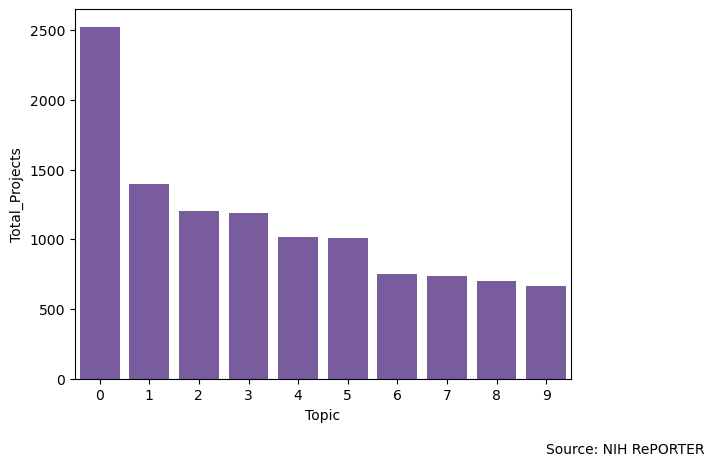

In [41]:
## Barplot function
# Note we can reference column names (in quotes) in the specified data:
# Change the color to steelblue
topic_count_graph = sns.barplot(x = 'Topic', 
                             y = 'Total_Projects', 
                             data = topic_count, 
                             color='#7851A9')


# add a data source 
# xy are measured in percent of axes length, from bottom left of graph:
plt.annotate('Source: NIH RePORTER', xy=(0.95,-0.20), xycoords="axes fraction")

plt.show()

### What is the average total cost per project?

In [42]:
# Calsulate the average total for projects in each topic
topic_avg_cost = topics_project_max.groupby('topic')['TOTAL_COST'].mean().sort_values(ascending = False)

# Convert into a dataframe and reset index
topic_avg_cost = topic_avg_cost.to_frame().reset_index()

# Rename the PI_NAMEs variable
topic_avg_cost = topic_avg_cost.rename(columns = {'TOTAL_COST': 'Average_Cost'})

# look at the first 5 observations
topic_avg_cost.head()

,topic,Average_Cost
0,"immun, cell, anti, tumor, dose, antibodi, toxic, therapi",651968.066980
1,"trial, care, health, communiti, nation, clinic, clinic trial, dispar",626739.347648
2,"imag, tissu, sampl, analysi, data, core, detect, perform",624626.532819
3,"member, fund, share, share resourc, center, resourc, cancer center, facil",608437.072331
4,"technolog, biolog, tool, throughput, sequenc, high throughput, comput, approach",551369.260700


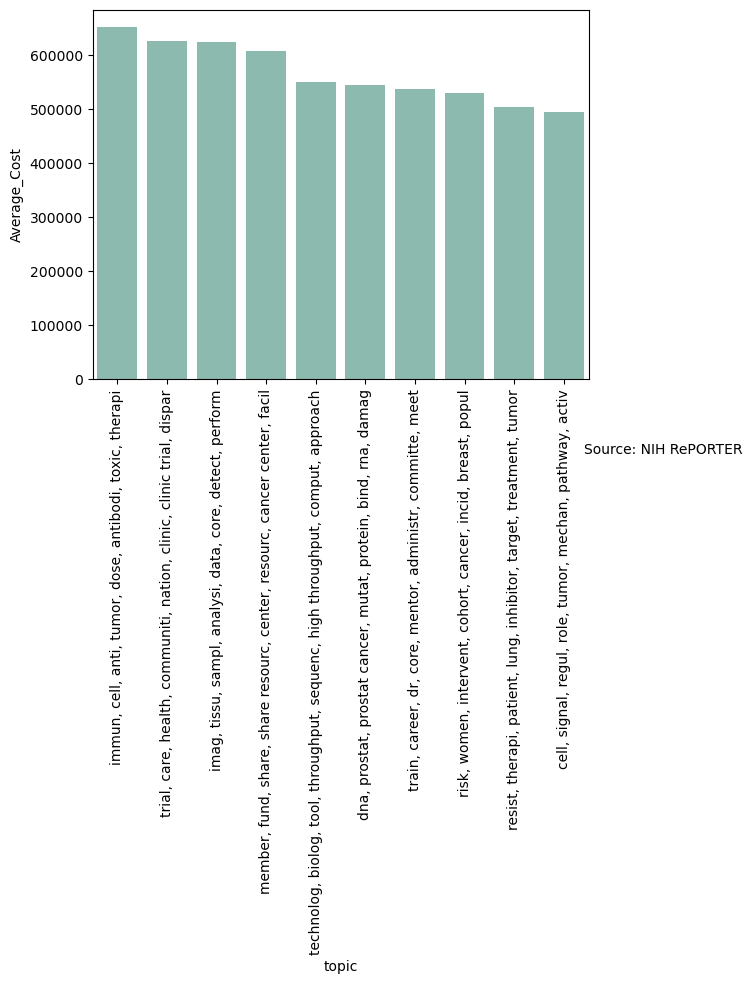

In [43]:
## Barplot function
# Note we can reference column names (in quotes) in the specified data:
# Change the color to steelblue
topic_cost_graph = sns.barplot(x = 'topic', 
                             y = 'Average_Cost', 
                             data = topic_avg_cost, 
                             color='#85c2b2')

#rotate x-axis labels
plt.xticks(rotation=90)

# add a data source 
# xy are measured in percent of axes length, from bottom left of graph:
plt.annotate('Source: NIH RePORTER', xy=(0.99,-0.20), xycoords="axes fraction")

plt.show()


### Supervised Learning: Document Classification

Topic modeling is an example of an unsupervised learning: we were looking to uncover structure in the form of topics, but we did not necessarily know the ground truth of how many topics there are.

We can also do supervised learning with text data. In supervised learning, we have a _known_ outcome or label (_Y_) that we want to produce given some data (_X_), and in general, we want to be able to produce this _Y_ when we _don't_ know it, or when we _only_ have _X_.

In order to produce labels we need to first have examples our algorithm can learn from, a "training set". In the context of text analysis, developing a training set can be very expensive, as it can require a large amount of human labor or linguistic expertise. **Document classification** is an example of supervised learning in which we want to characterize our documents based on their contents (_X_). A common example of document classification is spam e-mail detection. Another example of supervised learning in text analysis is _sentimenet analysis_, where _X_ is our documents and _Y_ is the state of the author. This "state" is dependent on the question you are trying to answer, and can range from the author being happy or unhappy with a product to the author being politically conservative or liberal. Another example is _part-of-speech tagging_ where _X_ are individual words and _Y_ is the part-of-speech.

### Further Resources

A great resource for NLP in Python is Natural Language Processing with Python: Analyzing Text with the Natural Language Toolkit.

Some of the most popular and useful Python libraries for NLP: 
- NLTK and the associated book/tutorial (www.nltk.org/book), a good introduction to different NLP tasks.
- TextBlob, a simplified library for various NLP tasks (noun phrase extraction, part-of-speech tagging, sentiment analysis, classification, tokenization, etc.).
- spaCy (named entity recognition, part-of-speech tagging, dependency parsing, tokenization, etc.).
- Stanford CoreNLP (while NLTK's emphasis is on simple reference implementations, Stanford CoreNLP is focused no fast implementations of cutting-edge algorithms, particularly for syntactic analysis, e.g. determining the subject of a sentence).

# Checkpoints <a class="Checkpoints" id="NLP"></a>
I would like you to turn in a notebook with only the checkpoints, ensuring that the notebook can run all the way through (you can hit the doubble arrow at the top of the notebook to restart the kernal and run the whole notebook through. 3 points will be automatically deducted if your notebook does not run all the way through after I change the Path
- For the name of the notebook you submit to brightspace, please use your first and last name followed by Text Analysis (for example: Maryah Garner Text Analysis.ipynb)

1) Install and import libraries (0 points, but if you don't include this your notebook will not run)

2) Create a path and read in the abstract data and project data for a year of your choice (0.5 points)

3) Join together the abstract and projects data and filter for projects funded by the CI most apporpriate for your class project (0.5 points)

4) Identify how many projects have missing abstracts and then remove the projects with missing abstracts from your dataframe (0.5 points)


5) Save your abstracts to list (0.5 points)

6) Set stemmer at SnowballStemmer (0.5 points)

7) Create a tokenize function (0.5 points)

8) Import and download stopwords form ltk.corpus (0.5 points)

9) Set the correct stop words and Tokenize them (0.5 points)

10) Create a list of other stopwords that you think might be useful to remove in order to create more meaningful topics (0.5 points)


11) Create the `vectorizer` object with the following specifications (0.5 points)
    - unit of features are single words rather than characters
    - function to create tokens
    - allow for bigrams
    - remove accent characters
    - remove stopwords
    - only include words with minimum frequency of 0.05
    - only include words with maximum frequency of 0.95

12) Create a bag of words/bigrams by fitting the vectorizer to your abstract list (0.5 points)

13) Use TfidfTransformer to re-weight your bag of words (0.5 points)

14) Fit your transormend data to an LDA model and store your results (0.5 points)

15) Pull out  the top keywords in each topic (0.5 points)

16) Save the results as a data frame with the top words for each topic as the colunn names  (0.5 points)

17) join together the dataframe from 16 with your abstracts dataframe (filtered for the CI)(0.5 points)

19) Choose one topic per document with the highest score (0.5 points)